In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

### Read in Test-Data to run feature matching algorithms on

In [2]:
testing_data = np.load("testing_data.npy",allow_pickle=True)
print("Read in: "+str(len(testing_data))+" images")

Read in: 24000 images


Verify data was read in correctly

Actual Label:[1. 0.]
Predicted Label:[1. 0.]


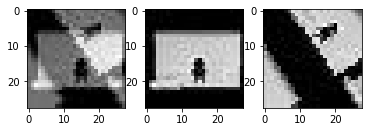

In [3]:
#change i to see a different test image
#if i is 0, should see first image in test-set
i = 2
f, ax = plt.subplots(1,3) 
plt.gray()
ax[0].imshow(testing_data[i][0])
ax[1].imshow(testing_data[i][1])
ax[2].imshow(testing_data[i][2])
print("Actual Label:"+str(testing_data[i][3]))
print("Predicted Label:"+str(testing_data[i][4]))

### Run this to select Model's Tagged Rigid Data

In [5]:
new_testing_data = []
for i in range(len(testing_data)):
    #Only put in Rigid images
    if(int(testing_data[i][4][0])==1):
        #Append Rigid Images
        new_testing_data.append(testing_data[i])
    else:
        #Do nothing for NonRigid Images
        pass
    
#Reassign test_data to Rigid-only
testing_data = new_testing_data

print(len(testing_data))

12023


### Brute-Force Matching with ORB Descriptors


Total Features Matches Found: 0
Average Features per Image: 0.0


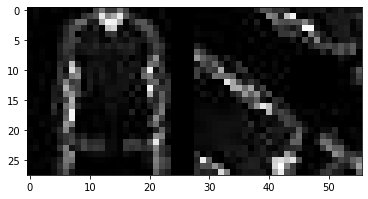

(<matplotlib.image.AxesImage at 0x1bb9073bf08>, None)

In [6]:
# img1 = cv.imread('box.png',cv.IMREAD_GRAYSCALE)          # queryImage
# img2 = cv.imread('box_in_scene.png',cv.IMREAD_GRAYSCALE) # trainImage

# img1 = cv.imread('original.jpg',cv.IMREAD_GRAYSCALE)          # queryImage
# img2 = cv.imread('original.jpg',cv.IMREAD_GRAYSCALE) # trainImage
#progress bar for training

total_matches = 0
valid_image_count = 0
invalid_image_count = 0


pbar = tqdm(range(len(testing_data)))
for i in pbar:
    try:
        img1 = testing_data[i][1]
        img2 = testing_data[i][2]

        # Initiate ORB detector
        orb = cv.ORB_create()
        # find the keypoints and descriptors with ORB
        kp1, des1 = orb.detectAndCompute(img1,None)
        kp2, des2 = orb.detectAndCompute(img2,None)

        # create BFMatcher object
        bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
        # Match descriptors.
        matches = bf.match(des1,des2)
        # Sort them in the order of their distance.
        matches = sorted(matches, key = lambda x:x.distance)
        total_matches += len(matches)
    except Exception as e:
        invalid_image_count += 1
        pass
# Draw matches.
print("Total Features Matches Found: "+str(total_matches))
print("Average Features per Image: "+str(total_matches/len(testing_data)))
img3 = cv.drawMatches(img1,kp1,img2,kp2,matches,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3),plt.show()

### Brute-Force Matching with SIFT Descriptors


Total Valid Images: 10832
Total Invalid Images: 1191
Total Features Matches Found: 45591
Total Bad Matches Found: 30645
Total Good Matches Found: 14946


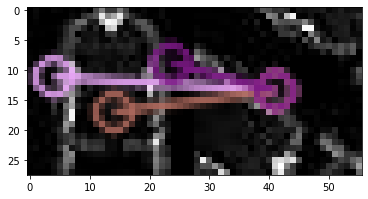

(<matplotlib.image.AxesImage at 0x1bb931bb2c8>, None)

In [7]:
total_matches = 0
valid_image_count = 0
invalid_image_count = 0
good_matches = 0

pbar = tqdm(range(len(testing_data)))
for i in pbar:
    try:
        img1 = testing_data[i][1]
        img2 = testing_data[i][2]
        # Initiate SIFT detector
        sift = cv.SIFT_create()

        # find the keypoints and descriptors with SIFT
        kp1, des1 = sift.detectAndCompute(img1,None)
        kp2, des2 = sift.detectAndCompute(img2,None)

        # BFMatcher with default params
        bf = cv.BFMatcher()
        matches = bf.knnMatch(des1,des2, k=2)

        # Apply ratio test
        good = []
        for m,n in matches:
            if m.distance < 0.75*n.distance:
                good.append([m])
        total_matches += len(matches)
        good_matches += len(good)
        valid_image_count +=1
    except Exception as e:
        invalid_image_count += 1
        pass

# Draw matches.
print("Total Valid Images: "+str(valid_image_count))
print("Total Invalid Images: "+str(invalid_image_count))
print("Total Features Matches Found: "+str(total_matches))
print("Total Bad Matches Found: "+str(total_matches-good_matches))
print("Total Good Matches Found: "+str(good_matches))
# cv2.drawMatchesKnn expects list of lists as matches.
img3 = cv.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=2)
plt.imshow(img3),plt.show()

### FLANN based Matcher with SIFT descriptors


Valid Images: 10832
Invalid Images: 1191
Total Feature Matches Found: 45591
Total Bad Matches: 32854
Total Good Matches: 12737


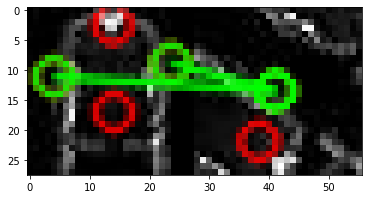

(<matplotlib.image.AxesImage at 0x1bb963bd3c8>, None)

In [8]:
# img1 = cv.imread('box.png',cv.IMREAD_GRAYSCALE)          # queryImage
# img2 = cv.imread('box_in_scene.png',cv.IMREAD_GRAYSCALE) # trainImage
total_matches = 0
false_matches = 0
true_matches = 0

valid_image_count = 0
invalid_image_count = 0
pbar = tqdm(range(len(testing_data)))
for f in pbar:
    try:
        img1 = testing_data[f][1]
        img2 = testing_data[f][2]

        # Initiate SIFT detector
        sift = cv.SIFT_create()
        # find the keypoints and descriptors with SIFT
        kp1, des1 = sift.detectAndCompute(img1,None)
        kp2, des2 = sift.detectAndCompute(img2,None)
        # FLANN parameters
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
        search_params = dict(checks=50)   # or pass empty dictionary
        flann = cv.FlannBasedMatcher(index_params,search_params)
        matches = flann.knnMatch(des1,des2,k=2)
        # Need to draw only good matches, so create a mask

        matchesMask = [[0,0] for i in range(len(matches))]
        # ratio test as per Lowe's paper
        for i,(m,n) in enumerate(matches):
            if m.distance < 0.7*n.distance:
                matchesMask[i]=[1,0]
        draw_params = dict(matchColor = (0,255,0),
                           singlePointColor = (255,0,0),
                           matchesMask = matchesMask,
                           flags = cv.DrawMatchesFlags_DEFAULT)

        #print number of matches
        total_matches += len(matches)
        for mask in draw_params['matchesMask']:
            if(mask)==[0,0]:
                false_matches += 1
            else:
                true_matches += 1
        valid_image_count += 1
    except Exception as e:
        invalid_image_count += 1
        pass
    
print("Valid Images: "+str(valid_image_count))
print("Invalid Images: "+str(invalid_image_count))
print("Total Feature Matches Found: "+str(total_matches))  
print("Total Bad Matches: "+str(false_matches))
print("Total Good Matches: "+str(true_matches))

img3 = cv.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,**draw_params)
plt.imshow(img3,),plt.show()

### RANSAC Matcher with SIFT descriptors


Valid Images: 8790
Invalid Images: 3233
Total Feature Matches Found: 33872
Total Bad Matches: 14500
Total Good Matches: 19372


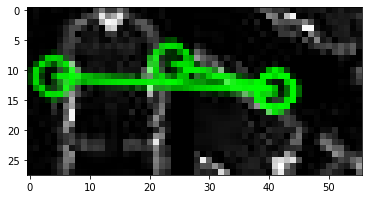

(<matplotlib.image.AxesImage at 0x1bb99508c08>, None)

In [9]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

total_matches = 0
false_matches = 0
true_matches = 0

valid_image_count = 0
invalid_image_count = 0


MIN_MATCH_COUNT = 1

# img1 = cv2.imread('box.png',0)          # queryImage
# img2 = cv2.imread('box_in_scene.png',0) # trainImage
pbar = tqdm(range(len(testing_data)))
for f in pbar:
    try:
        img1 = testing_data[f][1]
        img2 = testing_data[f][2]

        # Initiate SIFT detector
        sift = cv2.SIFT_create()

        # find the keypoints and descriptors with SIFT
        kp1, des1 = sift.detectAndCompute(img1,None)
        kp2, des2 = sift.detectAndCompute(img2,None)

        FLANN_INDEX_KDTREE = 0
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
        search_params = dict(checks = 50)

        flann = cv2.FlannBasedMatcher(index_params, search_params)

        matches = flann.knnMatch(des1,des2,k=2)

        # store all the good matches as per Lowe's ratio test.
        good = []
        for m,n in matches:
            if m.distance < 0.6*n.distance:
                good.append(m)

        if len(good)>MIN_MATCH_COUNT:
            src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
            dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

            M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
            matchesMask = mask.ravel().tolist()

            h,w = img1.shape
            pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
            dst = cv2.perspectiveTransform(pts,M)

            img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)

        else:
            matchesMask = None

        draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                           singlePointColor = None,
                           matchesMask = matchesMask, # draw only inliers
                           flags = 2)
        #print number of matches
        total_matches += len(matches)
        good_matches += len(good)
#         for mask in draw_params['matchesMask']:
#             if(mask)==1:
#                 true_matches += 1
#             else:
#                 false_matches += 1
                
        valid_image_count += 1
    except Exception as e:
        invalid_image_count += 1
        pass

#print number of matches
print("Valid Images: "+str(valid_image_count))
print("Invalid Images: "+str(invalid_image_count))
print("Total Feature Matches Found: "+str(total_matches))  
print("Total Bad Matches: "+str(total_matches-good_matches))
print("Total Good Matches: "+str(good_matches))

img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)

plt.imshow(img3, 'gray'),plt.show()